# Perceptron


## Give me some data
Let's create some linearly separable points

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data_around_straight_line(slope, intercept, num_data_points, x_min, x_max, separation_margin=0.01):
    """ Generates x,y pairs around the (slope * x + intercept) line
        Labels points below the line as a zero label
        Labels points above the line as a one label

    Parameters
    ----------
    slope : int
        slope of the line (the m from m*x +b)
    intercept : int
        y-intercept of the line (the b from m*x +b)
    num_data_points : int
        PER LABEL number of data points to generate:
        it will generate num_data_points with label 0 PLUS
        num_data_points with label 1
    x_min : int
        The min value of the X range
    x_max : int
        The max value of the X range
    separation_margin: float
        how far off x_min and x_max should the data points be generated

    Returns
    -------
    all_records
        2-D shuffled numpy array, ready for training
        1st column: x coordinate, 2nd: column y coordinate, 3rd: label
    """

    # range feature1 values between x_min and x_max
    feature_1_negative_label = np.round(np.random.uniform(low=x_min + separation_margin, high=x_max - separation_margin, size=num_data_points),
                                            decimals=2)
    feature_1_positive_label = np.round(np.random.uniform(low=x_min + separation_margin, high=x_max - separation_margin, size=num_data_points),
                                          decimals=2)

    feature2_low = slope * (x_min if slope > 0 else x_max) + intercept
    feature2_high = slope * (x_max if slope > 0 else x_min) + intercept

    feature_2_negative_label_line_points = slope * feature_1_negative_label + intercept
    feature_2_positive_label_line_points = slope * feature_1_positive_label + intercept

    feature_2_negative_label = []
    feature_2_positive_label = []
    for index in range(num_data_points):
        feature_2_negative_label.append(
            np.round(
                np.random.uniform(low=feature2_low + separation_margin, high=feature_2_negative_label_line_points[index] - separation_margin),
                decimals=2
            )
        )
        feature_2_positive_label.append(
            np.round(
                np.random.uniform(low=feature_2_positive_label_line_points[index] + separation_margin, high=feature2_high - separation_margin),
                decimals=2
            )
        )

    feature_2_negative_label = np.asarray(feature_2_negative_label)
    feature_2_positive_label = np.asarray(feature_2_positive_label)

    # since the perceptron will learn a line of the form a*x + b*y + c = 0
    # x will be our x-coordinate(feature1), y will be our y coordinate(feature2)
    # a, b and c will make up our weights vector - w1, w2 and w3
    bias_filler_feature = np.ones(num_data_points)

    negative_labels = -1 * np.ones(num_data_points)
    positive_labels = np.ones(num_data_points)

    # build the ML matrix
    # x-coordinate | y-coordinate | ones_for_the_bias | label
    # -------------------------------------------------------
    zero_records = np.vstack((feature_1_negative_label, feature_2_negative_label, bias_filler_feature,
                              negative_labels)).T
    one_records = np.vstack((feature_1_positive_label, feature_2_positive_label, bias_filler_feature,
                             positive_labels)).T

    all_records = np.vstack((zero_records, one_records))
    np.random.shuffle(all_records)

    return all_records

## Show me te data
Let's plot the training records:


In [231]:
def plot_records(records, slope, intercept, x_min, x_max):

    negative_records = records[records[:, 3] == -1]
    positive_records = records[records[:, 3] == 1]

    feature_1_negative_label = negative_records[:, 0]
    feature_2_negative_label = negative_records[:, 1]

    feature_1_positive_label = positive_records[:, 0]
    feature_2_positive_label = positive_records[:, 1]

    feature2_low = slope * (x_min if slope > 0 else x_max) + intercept
    feature2_high = slope * (x_max if slope > 0 else x_min) + intercept

    plt.scatter(feature_1_negative_label, feature_2_negative_label, c='red', marker="x")
    plt.scatter(feature_1_positive_label, feature_2_positive_label, c='green', marker="x")

    plt.axline((x_min, feature2_low if slope > 0 else feature2_high),
               (x_max, feature2_high if slope > 0 else feature2_low), c='blue')
    return plt

First Moment of truth: Let's generate training data and plot it.
Positive slope line:


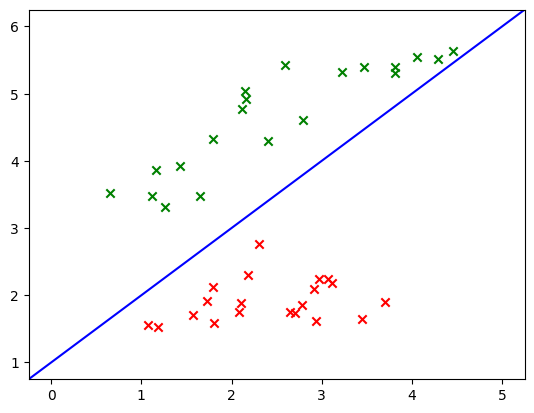

In [232]:
this_slope = 1
this_intercept = 1
this_num_data_points = 20
this_x_min = 0
this_x_max = 5
this_separation_margin = 0.5

training_records = generate_data_around_straight_line(slope=this_slope, intercept=this_intercept,
                                                      num_data_points=this_num_data_points, x_min=this_x_min,
                                                      x_max=this_x_max, separation_margin=this_separation_margin)

this_plot = plot_records(records=training_records, slope=this_slope, intercept=this_intercept, x_min=this_x_min,
                         x_max=this_x_max)
this_plot.show()


And a negative slope?


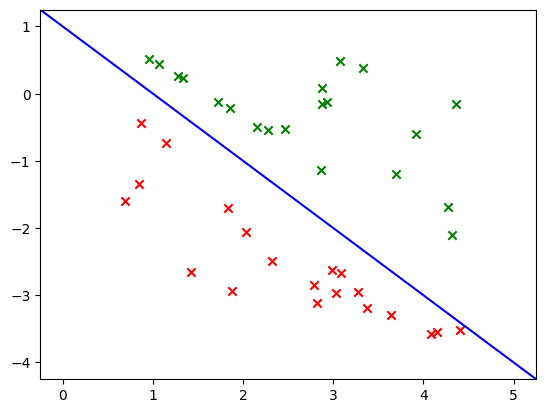

In [233]:
this_slope = -1

this_training_records = generate_data_around_straight_line(slope=this_slope, intercept=this_intercept,
                                                      num_data_points=this_num_data_points, x_min=this_x_min,
                                                      x_max=this_x_max, separation_margin=this_separation_margin)

this_plot = plot_records(records=this_training_records, slope=this_slope, intercept=this_intercept, x_min=this_x_min,
             x_max=this_x_max)
this_plot.show()

## Machine Learning
Let's see if we can come up with logic that tells blue from green dots

First up, Stochastic Perceptron.
Generic Pseudocode:

```
For each training record
    predict: step_function(weights dot training_record_features)
    if prediction is incorrect
        adjust the weights in the direction of correctness
```

In [234]:
def sign(z):
    return np.where(z >= 0, 1, -1)

def accuracy(labels, projections):
    return np.sum(labels == projections)/labels.shape[0]

def do_stochastic_perceptron(feature_data, labels, learning_rate, initial_weights, num_epochs=1):

    weights = initial_weights
    for epoch in range(num_epochs):
        for i in range(feature_data.shape[0]):
            feature_data_record = feature_data[i, :]
            label = labels[i]
            predicted_label = sign(np.dot(feature_data_record, weights))
            error = label - predicted_label
            # possible values
            # actual: 1, predicted: 1, error: 0; actual: -1, predicted: -1; error: 0
            # actual: 1, predicted: -1, error: 2; actual: -1, predicted: 1, error: -2
            # since we just need to indicate we made an error, we just divide by two
            error = error/2

            # perceptron rule
            delta_weights = learning_rate * error * feature_data_record
            weights = weights + np.reshape(delta_weights, (weights.shape[0], weights.shape[1]))
            # this is the same as saying
            # if error == 0 - do nothing - delta_weights will be zero
            # elif label == 1 and abs(error) > 0 - increase weights
            # elif label == -1 and abs(error) > 0 - decrease weights

            projections = sign(np.dot(feature_data, weights))
            accuracy_score = accuracy(labels, projections)
            if i % 50 == 0:
                print(f'i: {i}, new_accuracy: {accuracy_score}')

            if accuracy_score == 1:
                print("Perfect Accuracy weights: ")
                print(f'epoch: {epoch}, iteration: {i}')
                return weights

    return weights


For ease, let's go with a positive slope and positive intercept

In [235]:
this_slope = 2
this_intercept = 2
this_num_data_points = 500
this_separation_margin = 0.2

this_training_records = generate_data_around_straight_line(slope=this_slope, intercept=this_intercept,
                                                      num_data_points=this_num_data_points, x_min=this_x_min,
                                                      x_max=this_x_max, separation_margin=this_separation_margin)

this_num_features = this_training_records.shape[1] - 1

this_init_weights = np.zeros((this_num_features, 1))

this_feature_data = this_training_records[:, :this_num_features]
this_labels = np.reshape(this_training_records[:, -1], (this_training_records.shape[0], 1))

this_learning_rate = 0.01
this_num_epochs = 10

learned_weights = do_stochastic_perceptron(this_feature_data, this_labels, this_learning_rate, this_init_weights,
                                          this_num_epochs)

print(f'learned_weights:\n{learned_weights}')

i: 0, new_accuracy: 0.5
i: 50, new_accuracy: 0.529
i: 100, new_accuracy: 0.648
i: 150, new_accuracy: 0.815
i: 200, new_accuracy: 0.599
i: 250, new_accuracy: 0.961
i: 300, new_accuracy: 0.991
i: 350, new_accuracy: 0.991
i: 400, new_accuracy: 0.991
i: 450, new_accuracy: 0.991
i: 500, new_accuracy: 0.854
i: 550, new_accuracy: 0.773
i: 600, new_accuracy: 0.976
i: 650, new_accuracy: 0.976
i: 700, new_accuracy: 0.991
i: 750, new_accuracy: 0.955
i: 800, new_accuracy: 0.642
i: 850, new_accuracy: 0.988
Perfect Accuracy weights: 
epoch: 0, iteration: 878
learned_weights: [[-0.3321]
 [ 0.1706]
 [-0.34  ]]


The learned weights are a vector
whose dot product with a green point(positive class) should result in 1, and
whose dot product with a red point(negative class) should result in -1.
The dot product of the weight vector and any point on the decision boundary line should result in 0.
The last statement should help us find 2 points on the learned decision boundary, so we can plot it.
Since our data is in the format of x, y, 1

$$w_1*x + w_2*y + w3*1 = 0$$

we will set x = 0 to find y - this will give us the first point - (0, y):

$$w_1*0 + w_2*y + w_3 = 0 =>$$

$$y = -w_3/w_2 =>$$

$$Point_1: (0, -w_3/w_2)$$

we will set y = 0 to find x - this will give us the second point - (x, 0):

$$w_1*x + w_2*0 + w_3 = 0 =>$$

$$x =-w_3/w_1 => $$

$$Point_2 = (-w_3/w_1, 0)$$

learned slope: 1.9466588511137173
learned y_intercept: 1.992966002344667


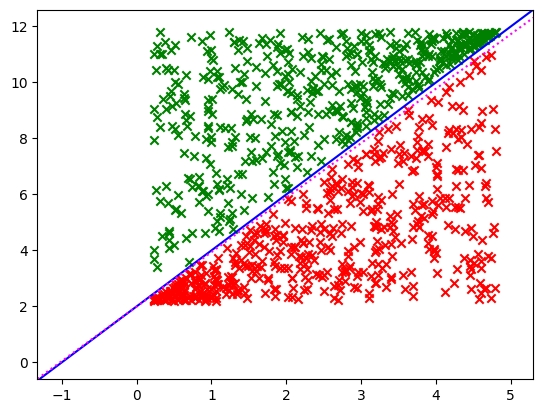

In [236]:
def plot_decision_boundary(plot_of_records_and_actual_boundary, weights):

    w1 = weights[0, 0]
    w2 = weights[1, 0]
    w3 = weights[2, 0]

    decision_boundary_x1 = 0
    decision_boundary_y1 = -w3/w2

    decision_boundary_x2 = -w3/w1
    decision_boundary_y2 = 0

    # rise over run
    m = (decision_boundary_y2 - decision_boundary_y1)/(decision_boundary_x2 - decision_boundary_x1)
    print(f'learned slope: {m}')
    y_intercept = decision_boundary_y1
    print(f'learned y_intercept: {y_intercept}')

    # Now let's plot the points with the actual decision boundary(blue) and the learned one(magenta dotted)
    plot_of_records_and_actual_boundary.axline((decision_boundary_x1, decision_boundary_y1), (decision_boundary_x2, decision_boundary_y2),
                     c='magenta', linestyle="dotted")

    return plot_of_records_and_actual_boundary


this_plot = plot_records(records=this_training_records, slope=this_slope, intercept=this_intercept, x_min=this_x_min,
                  x_max=this_x_max)
this_plot = plot_decision_boundary(this_plot, learned_weights)
this_plot.show()


Not too shabby! For even better results, we could increase the num_data_points, and/or reduce the separation_margin.

Let's try batch perceptron! Why loop when we have numpy?

Weight Update would happen only once per epoch. IE, we would accumulate the delta in weights for all training records,

sum these deltas, then use that for the weight update.


epoch: 0, accuracy: 0.5
epoch: 1, accuracy: 0.5
epoch: 2, accuracy: 0.692
epoch: 3, accuracy: 0.5
epoch: 4, accuracy: 0.628
epoch: 5, accuracy: 0.5
epoch: 6, accuracy: 0.5
epoch: 7, accuracy: 0.601
epoch: 8, accuracy: 0.5
epoch: 9, accuracy: 0.5
epoch: 10, accuracy: 0.614
epoch: 11, accuracy: 0.61
epoch: 12, accuracy: 0.511
epoch: 13, accuracy: 0.748
epoch: 14, accuracy: 0.669
epoch: 15, accuracy: 0.536
epoch: 16, accuracy: 0.843
epoch: 17, accuracy: 0.756
epoch: 18, accuracy: 0.572
epoch: 19, accuracy: 0.854
epoch: 20, accuracy: 0.714
epoch: 21, accuracy: 0.73
epoch: 22, accuracy: 0.575
epoch: 23, accuracy: 0.942
epoch: 24, accuracy: 0.862
epoch: 25, accuracy: 0.713
epoch: 26, accuracy: 0.751
epoch: 27, accuracy: 0.591
epoch: 28, accuracy: 0.927
epoch: 29, accuracy: 0.884
epoch: 30, accuracy: 0.839
epoch: 31, accuracy: 0.663
epoch: 32, accuracy: 0.828
epoch: 33, accuracy: 0.646
epoch: 34, accuracy: 0.845
epoch: 35, accuracy: 0.677
epoch: 36, accuracy: 0.852
epoch: 37, accuracy: 0.683


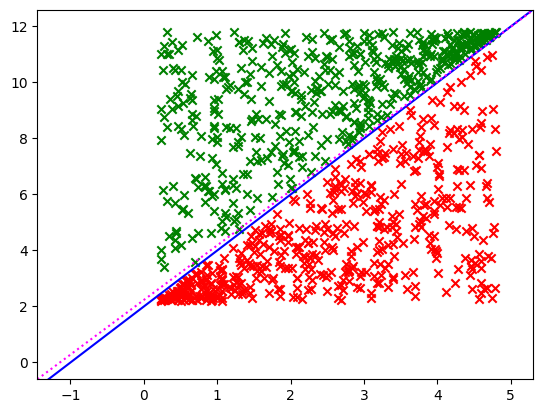

In [237]:
def do_batch_perceptron(feature_data, labels, learning_rate, init_weights, num_epochs, batch_size=None):

    weights = init_weights
    for epoch in range(num_epochs):

        predicted_labels = sign(np.dot(feature_data, weights))
        # see comment in stochastic perceptron why we divide by 2
        errors = (labels - predicted_labels)/2
        delta_weights = learning_rate * errors * feature_data
        weights = weights + np.sum(delta_weights, axis=0, keepdims=True).T

        projections = sign(np.dot(feature_data, weights))
        accuracy_score = accuracy(labels, projections)

        print(f'epoch: {epoch}, accuracy: {accuracy_score}')

        if accuracy_score == 1:
            print("Perfect Accuracy weights: ")
            print(f'epoch: {epoch}')
            return weights

    return weights

this_num_epochs = 150
learned_batch_weights = do_batch_perceptron(this_feature_data, this_labels, this_learning_rate, this_init_weights,
                                          this_num_epochs)

this_plot = plot_records(records=this_training_records, slope=this_slope, intercept=this_intercept, x_min=this_x_min,
                  x_max=this_x_max)
this_plot = plot_decision_boundary(this_plot, learned_batch_weights)
this_plot.show()

Not Bad! Let's see if we can do mini-batches. They are between stochastic and batch.

Stochastic is really a batch of 1 record. Batch is really a batch of ALL records.

Now we will add the ability to batch more than one record, but fewer than all the records.


num_batches: 77
num_records_last_batch: 12
batch 1, records: 13
epoch: 1, batch: 1, accuracy: 0.5
batch 2, records: 13
epoch: 1, batch: 2, accuracy: 0.539
batch 3, records: 13
epoch: 1, batch: 3, accuracy: 0.5
batch 4, records: 13
epoch: 1, batch: 4, accuracy: 0.5
batch 5, records: 13
epoch: 1, batch: 5, accuracy: 0.5
batch 6, records: 13
epoch: 1, batch: 6, accuracy: 0.513
batch 7, records: 13
epoch: 1, batch: 7, accuracy: 0.529
batch 8, records: 13
epoch: 1, batch: 8, accuracy: 0.565
batch 9, records: 13
epoch: 1, batch: 9, accuracy: 0.5
batch 10, records: 13
epoch: 1, batch: 10, accuracy: 0.51
batch 11, records: 13
epoch: 1, batch: 11, accuracy: 0.621
batch 12, records: 13
epoch: 1, batch: 12, accuracy: 0.815
batch 13, records: 13
epoch: 1, batch: 13, accuracy: 0.827
batch 14, records: 13
epoch: 1, batch: 14, accuracy: 0.526
batch 15, records: 13
epoch: 1, batch: 15, accuracy: 0.562
batch 16, records: 13
epoch: 1, batch: 16, accuracy: 0.51
batch 17, records: 13
epoch: 1, batch: 17, 

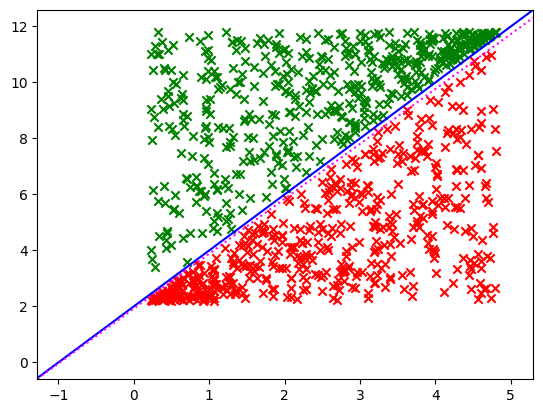

In [238]:
import math

def do_mini_batch_perceptron(feature_data, labels, learning_rate, init_weights, num_epochs, batch_size):

    num_records = feature_data.shape[0]
    num_batches = num_records/batch_size

    if not num_batches.is_integer():
        num_batches = math.ceil(num_batches)
        num_records_last_batch = num_records - ((num_batches - 1) * batch_size)
    else:
        num_records_last_batch = batch_size

    print(f'num_batches: {num_batches}')
    print(f'num_records_last_batch: {num_records_last_batch}')

    weights = init_weights
    for epoch in range(num_epochs):
        for batch_number in range(int(num_batches)):
            num_records_in_batch = batch_size if batch_number < (num_batches - 1) else num_records_last_batch
            print(f'batch {batch_number + 1}, records: {num_records_in_batch}')

            batch_start_idx = batch_number * batch_size
            batch_end_idx = batch_start_idx + num_records_in_batch
            feature_data_this_batch = feature_data[batch_start_idx:batch_end_idx, :]
            labels_this_batch = labels[batch_start_idx:batch_end_idx]

            predicted_labels = sign(np.dot(feature_data_this_batch, weights))
            # see comment in stochastic perceptron why we divide by 2
            errors = (labels_this_batch - predicted_labels)/2
            delta_weights = learning_rate * errors * feature_data_this_batch
            weights = weights + np.sum(delta_weights, axis=0, keepdims=True).T

            projections = sign(np.dot(feature_data, weights))
            accuracy_score = accuracy(labels, projections)

            print(f'epoch: {epoch + 1}, batch: {batch_number + 1}, accuracy: {accuracy_score}')

            if accuracy_score == 1:
                print("Perfect Accuracy weights: ")
                print(f'epoch: {epoch + 1}, batch: {batch_number + 1}')
                return weights

    return weights

this_num_epochs = 5
this_batch_size = 13
learned_mini_batch_weights = do_mini_batch_perceptron(this_feature_data, this_labels, this_learning_rate, this_init_weights,
                                          this_num_epochs, this_batch_size)
print('flearned_mini_batch_weights:\n{learned_mini_batch_weights}')

this_plot = plot_records(records=this_training_records, slope=this_slope, intercept=this_intercept, x_min=this_x_min,
                  x_max=this_x_max)
this_plot = plot_decision_boundary(this_plot, learned_mini_batch_weights)
this_plot.show()

Sweet! Next up Logistic Regression.

The logic should be identical to perceptron, except the activation function would be a sigmoid or tanh, instead of sign.

Cheers!